# Time series forecasting with ARIMA

In this notebook, we demonstrate how to:
- prepare time series data for training an ARIMA time series forecasting model
- implement a simple ARIMA model to forecast the next HORIZON steps ahead (time *t+1* through *t+HORIZON*) in the time series
- evaluate the model 


The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

In [6]:
energy = load_data("./data")[["load"]]
energy.head(10)

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"
2012-01-01 05:00:00,"2,453.00"
2012-01-01 06:00:00,"2,560.00"
2012-01-01 07:00:00,"2,719.00"
2012-01-01 08:00:00,"2,916.00"
2012-01-01 09:00:00,"3,105.00"


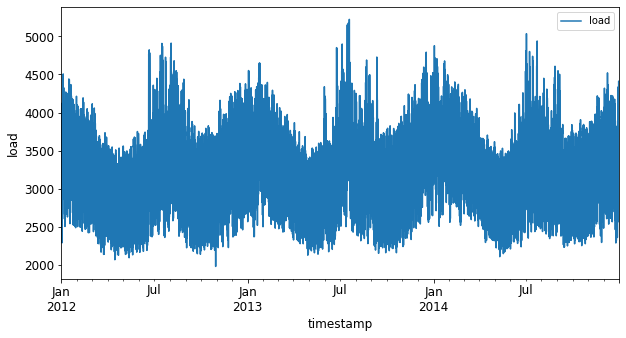

In [7]:
energy.plot(y="load", figsize=(10, 5), fontsize=12)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

"Allocate a two-month period from September 1 to October 31, 2014 to the training set. The test set will include the two-month period of November 1 to December 31, 2014:"

This is what it says in instructions, then it proceeeds with following dates:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

Now, maybe I don't understand something, but according to that text, it should be:
train_start_dt  = "2014-09-01 00:00:00"
test_start_dt  = "2014-11-01 00:00:00"

I'll assume the code is right and go with 2 month train data and 2 day test.
...

In [22]:
train_start_dt  = "2014-11-01 00:00:00"
test_start_dt  = "2014-12-30 00:00:00"



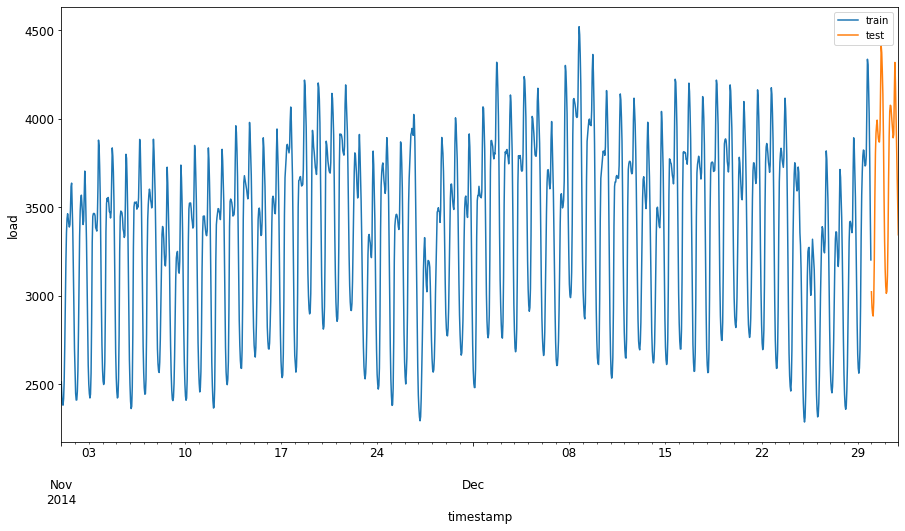

In [23]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][["load"]].rename(columns={"load":"train"}) \
    .join(energy[test_start_dt:][["load"]].rename(columns={"load":"test"}), how="outer") \
    .plot(y=["train", "test"], figsize=(15, 8), fontsize=12)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

In [24]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [25]:
scaler = MinMaxScaler()
train["load"] = scaler.fit_transform(train)
train.head(10)

,load
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06
2014-11-01 05:00:00,0.10
2014-11-01 06:00:00,0.19
2014-11-01 07:00:00,0.31
2014-11-01 08:00:00,0.40
2014-11-01 09:00:00,0.48


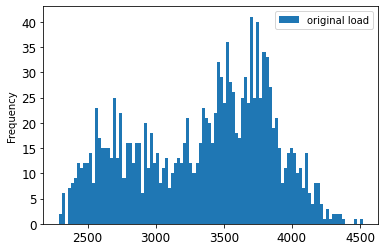

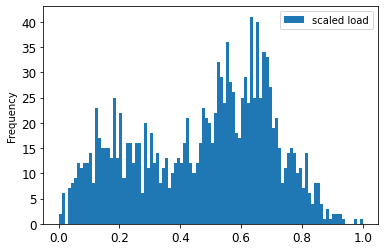

In [26]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][["load"]].rename(columns={"load":"original load"}).plot.hist(bins=100, fontsize=12)
train.rename(columns={"load":"scaled load"}).plot.hist(bins=100, fontsize=12)
plt.show()

In [27]:
test["load"] = scaler.transform(test)
test.head()

,load
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


In [32]:
HORIZON = 2
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 2 hours


In [33]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.240
Date:                            Sun, 17 Oct 2021   AIC                          -6942.481
Time:                                    15:38:16   BIC                          -6911.054
Sample:                                11-01-2014   HQIC                         -6930.729
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8403      0.016     52.083      0.000       0.809       0.872
ar.L2         -0.5231      0.034   

In [34]:
test_shifted = test.copy()

for t in range(1, HORIZON+1):
    test_shifted["load+"+str(t)] = test_shifted["load"].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how="any")
test_shifted.head(5)

,load,load+1,load+2
2014-12-30 00:00:00,0.33,0.29,0.27
2014-12-30 01:00:00,0.29,0.27,0.27
2014-12-30 02:00:00,0.27,0.27,0.30
2014-12-30 03:00:00,0.27,0.30,0.41
2014-12-30 04:00:00,0.30,0.41,0.57


In [36]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train["load"]
test_ts = test_shifted

history = [x for x in train_ts]
# get only last 30 days
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    # make SARIMA model
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    # predict
    yhat = model_fit.forecast(steps = HORIZON+1)
    predictions.append(yhat)
    # actual value
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)

    print(test_ts.index[t])
    print(t+1, ": predicted =", yhat, "expected =", obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]


C:\Users\blazr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]


C:\Users\blazr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.7511190689346463]
2014-12-30 08:00:00
9 : predicted = [0.75 0.8  0.82] expected = [0.7309758281110115, 0.7511190689346463, 0.7636526410026856]
2014-12-30 09:00:00
10 : predicted = [0.77 0.78 0.78] expected = [0.7511190689346463, 0.7636526410026856, 0.7381378692927483]


C:\Users\blazr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 10:00:00
11 : predicted = [0.76 0.75 0.74] expected = [0.7636526410026856, 0.7381378692927483, 0.7188898836168307]
2014-12-30 11:00:00
12 : predicted = [0.77 0.76 0.75] expected = [0.7381378692927483, 0.7188898836168307, 0.7090420769919425]
2014-12-30 12:00:00
13 : predicted = [0.7  0.68 0.69] expected = [0.7188898836168307, 0.7090420769919425, 0.7081468218442255]
2014-12-30 13:00:00
14 : predicted = [0.72 0.73 0.76] expected = [0.7090420769919425, 0.7081468218442255, 0.7385854968666068]
2014-12-30 14:00:00
15 : predicted = [0.71 0.73 0.86] expected = [0.7081468218442255, 0.7385854968666068, 0.8478066248880931]
2014-12-30 15:00:00
16 : predicted = [0.73 0.85 0.97] expected = [0.7385854968666068, 0.8478066248880931, 0.9516562220232765]
2014-12-30 16:00:00
17 : predicted = [0.87 0.99 0.97] expected = [0.8478066248880931, 0.9516562220232765, 0.934198746642793]
2014-12-30 17:00:00
18 : predicted = [0.94 0.92 0.86] expected = [0.9516562220232765, 0.934198746642793, 0.887645478961

C:\Users\blazr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 20:00:00
21 : predicted = [0.83 0.72 0.58] expected = [0.8294538943598924, 0.7197851387645477, 0.5747538048343777]
2014-12-30 21:00:00
22 : predicted = [0.72 0.58 0.47] expected = [0.7197851387645477, 0.5747538048343777, 0.4592658907788718]
2014-12-30 22:00:00
23 : predicted = [0.58 0.47 0.39] expected = [0.5747538048343777, 0.4592658907788718, 0.3858549686660697]
2014-12-30 23:00:00
24 : predicted = [0.46 0.38 0.34] expected = [0.4592658907788718, 0.3858549686660697, 0.34377797672336596]
2014-12-31 00:00:00
25 : predicted = [0.38 0.34 0.33] expected = [0.3858549686660697, 0.34377797672336596, 0.32542524619516544]
2014-12-31 01:00:00
26 : predicted = [0.36 0.34 0.34] expected = [0.34377797672336596, 0.32542524619516544, 0.33034914950760963]
2014-12-31 02:00:00
27 : predicted = [0.32 0.32 0.35] expected = [0.32542524619516544, 0.33034914950760963, 0.3706356311548791]
2014-12-31 03:00:00
28 : predicted = [0.32 0.36 0.47] expected = [0.33034914950760963, 0.3706356311548791, 0.4

C:\Users\blazr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 05:00:00
30 : predicted = [0.48 0.64 0.75] expected = [0.470008952551477, 0.6145926589077886, 0.7247090420769919]
2014-12-31 06:00:00
31 : predicted = [0.63 0.73 0.79] expected = [0.6145926589077886, 0.7247090420769919, 0.786034019695613]
2014-12-31 07:00:00
32 : predicted = [0.71 0.76 0.79] expected = [0.7247090420769919, 0.786034019695613, 0.8012533572068039]
2014-12-31 08:00:00
33 : predicted = [0.78 0.82 0.83] expected = [0.786034019695613, 0.8012533572068039, 0.7994628469113696]
2014-12-31 09:00:00
34 : predicted = [0.82 0.83 0.81] expected = [0.8012533572068039, 0.7994628469113696, 0.780214861235452]


C:\Users\blazr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 10:00:00
35 : predicted = [0.8  0.78 0.76] expected = [0.7994628469113696, 0.780214861235452, 0.7587287376902416]
2014-12-31 11:00:00
36 : predicted = [0.77 0.75 0.74] expected = [0.780214861235452, 0.7587287376902416, 0.7367949865711727]
2014-12-31 12:00:00
37 : predicted = [0.77 0.76 0.76] expected = [0.7587287376902416, 0.7367949865711727, 0.7188898836168307]
2014-12-31 13:00:00
38 : predicted = [0.75 0.75 0.78] expected = [0.7367949865711727, 0.7188898836168307, 0.7273948075201431]
2014-12-31 14:00:00
39 : predicted = [0.73 0.75 0.87] expected = [0.7188898836168307, 0.7273948075201431, 0.8299015219337511]
2014-12-31 15:00:00
40 : predicted = [0.74 0.85 0.96] expected = [0.7273948075201431, 0.8299015219337511, 0.909579230080573]
2014-12-31 16:00:00
41 : predicted = [0.83 0.94 0.93] expected = [0.8299015219337511, 0.909579230080573, 0.855863921217547]
2014-12-31 17:00:00
42 : predicted = [0.94 0.93 0.88] expected = [0.909579230080573, 0.855863921217547, 0.7721575649059982]

In [42]:
eval_df = pd.DataFrame(predictions, columns=["t+"+str(t) for t in range(1, HORIZON+2)])
eval_df["timestamp"] = test.index[0:len(test.index)-HORIZON]
eval_df = pd.melt(eval_df, id_vars="timestamp", value_name="prediction", var_name='h')
eval_df["actual"] = np.array(np.transpose(test_ts)).ravel()
eval_df[["prediction", "actual"]] = scaler.inverse_transform(eval_df[["prediction", "actual"]])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-12-30 00:00:00,t+1,"3,008.99","3,023.00"
1,2014-12-30 01:00:00,t+1,"2,955.67","2,935.00"
2,2014-12-30 02:00:00,t+1,"2,900.09","2,899.00"
3,2014-12-30 03:00:00,t+1,"2,917.72","2,886.00"
4,2014-12-30 04:00:00,t+1,"2,946.51","2,963.00"


In [44]:
eval_df["APE"] = (eval_df["prediction"] - eval_df["actual"]).abs() / eval_df["actual"]
print(eval_df.groupby('h')["APE"].mean())

h
t+1   0.01
t+2   0.01
t+3   0.02
Name: APE, dtype: float64


In [45]:
print("One step forecast MAPE: ", (mape(eval_df[eval_df['h'] == "t+1"]["prediction"], eval_df[eval_df['h'] == "t+1"]["actual"]))*100, '%')


One step forecast MAPE:  0.5563597537440257 %


In [46]:
print("Multi-step forecast MAPE: ", mape(eval_df["prediction"], eval_df["actual"])*100, '%')


Multi-step forecast MAPE:  1.1447582210206828 %


No handles with labels found to put in legend.


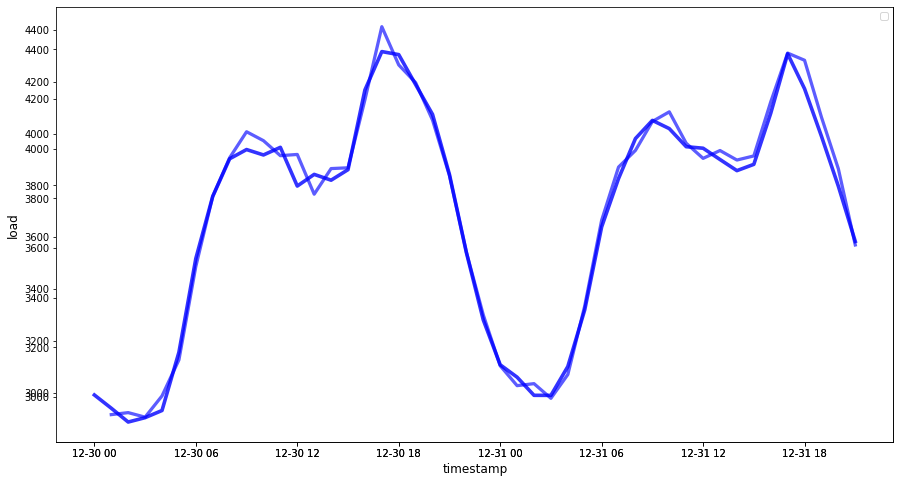

In [48]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x="timestamp", y=["actual", "prediction"], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=="t+1")][["timestamp", "actual"]]
    for t in range(1, HORIZON+1):
        plot_df["t+"+str(t)] = eval_df[(eval_df.h=="t+"+str(t))]["prediction"].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df["timestamp"], plot_df["actual"], color="red", linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df["timestamp"][(t-1):]
        y = plot_df["t+"+str(t)][0:len(x)]
        ax.plot(x, y, color="blue", linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))

    ax.legend(loc="best")

plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()